In [8]:
import sys
import os
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline

Text(0.5,1,'clean image')

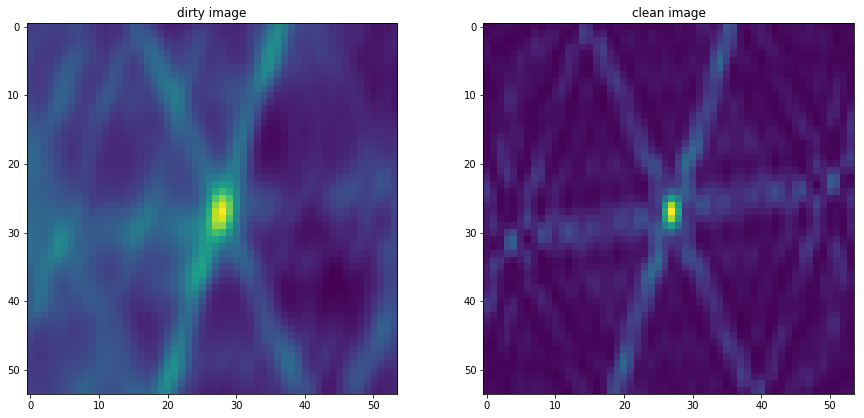

In [35]:
folder = "./img-csv/54x54pixels/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',')
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',')
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',')

dimensions = dirty_map.size
dirty_flat = dirty_map.flatten()


fig1 = plt.figure(figsize = (15,15))

sub0 = fig1.add_subplot(2,2,1)
sub0.imshow(np.transpose(dirty_map))
sub0.set_title('dirty image')

sub1 = fig1.add_subplot(2,2,2)
sub1.imshow(np.transpose(clean_map))
sub1.set_title('clean image')

Setting up parameters and objective function

In [36]:
val_lambda = 0.05

def objective_function(x):
    l2 = np.sum(np.square(np.abs(dirty_flat[0:54] - x)))
    l1 = 0 #l1 = np.sum(np.abs(np.dot(haar_transform, x)))
    return l2 + val_lambda * l1

In [37]:

#x0 = np.zeros(dimensions[0]* dimensions[1])
x0 = np.zeros(54)
result = minimize(objective_function, x0,method="nelder-mead", options={'xtol': 1e-3, 'disp': True})
print(result.fun)

296.72867652919643


ValueError: cannot reshape array of size 54 into shape (2916,)

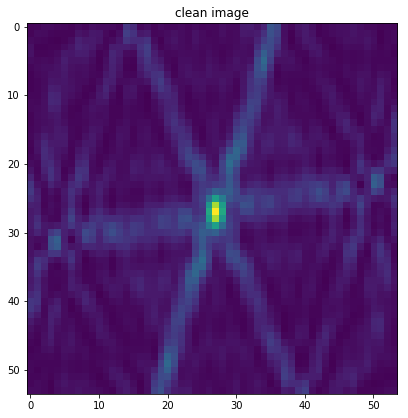

In [41]:
fig2 = plt.figure(figsize = (15,15))

sub0 = fig2.add_subplot(2,2,1)
sub0.imshow(np.transpose(clean_map))
sub0.set_title('clean image')

reconstructed = np.reshape(result.x, dimensions)
sub1 = fig2.add_subplot(2,2,2)
sub1.imshow(np.transpose(reconstructed))
sub1.set_title('reconstruced image')